In [1]:
%load_ext autoreload
%autoreload 2

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series


from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, train_val_split, calculate_loss
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, plot_forecast, get_forecast

## Comparison of E/Hosp and I/Hosp ratios

In [ ]:
for district in predictions_dict.keys():
    district_dict = predictions_dict[district]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-', color='C0', label='E / Hosp (M1)')
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-.', color='C0', label='I / Hosp (M1)')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
    plt.grid()
    plt.show()

## Load Covid19india Data

In [14]:
dataframes = get_covid19india_api_data()

In [15]:
predictions_dict = {}

## Select Districts to fit on

In [16]:
# districts_to_show = [('Maharashtra', 'Pune'), 
#                      ('Maharashtra', 'Mumbai'), 
#                      ('Rajasthan', 'Jaipur'), 
#                      ('Gujarat', 'Ahmedabad'), 
#                      ('Karnataka', 'Bengaluru Urban'),
#                      ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Pune')]
#districts_to_show = [('Maharashtra', 'Mumbai')]

## Perform M1 and M2 fits

In [17]:
#for state, district in districts_to_show:
#    predictions_dict[(state, district)] = {}
#    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
#                                                                     data_from_tracker=True, initialisation='intermediate',
#                                                                     which_compartments=['hospitalised', 'total_infected'])
#    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, 
#                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
#                                                                     which_compartments=['hospitalised', 'total_infected'])

fitting to data with "train_on_val" set to False ..
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
23 2020-05-14  Maharashtra     Pune          2987.2        1337.8     1480.0   
24 2020-05-15  Maharashtra     Pune          3139.0        1373.6     1588.4   
25 2020-05-16  Maharashtra     Pune          3293.8        1436.6     1673.0   
26 2020-05-17  Maharashtra     Pune          3445.8        1496.2     1757.8   
27 2020-05-18  Maharashtra     Pune          3607.0        1569.6     1836.4   

    deceased  
23     169.4  
24     177.0  
25     184.2  
26     191.8  
27     201.2  
val
         date        state district  total_infected  hospitalised  recovered  \
0 2020-05-19  Maharashtra     Pune          3769.4        1626.8     1933.2   
1 2020-05-20  Maharashtra     Pune          3949.8        1673.8     2057.2   
2 2020-05-21  Maharashtra     Pune          4150.8        1732.4     2189.8   
3 2020-05-22 

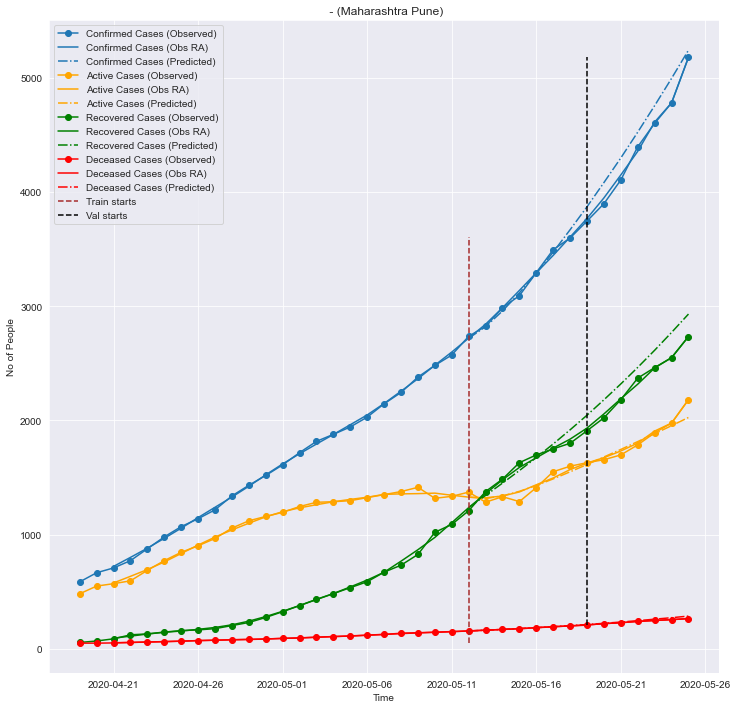

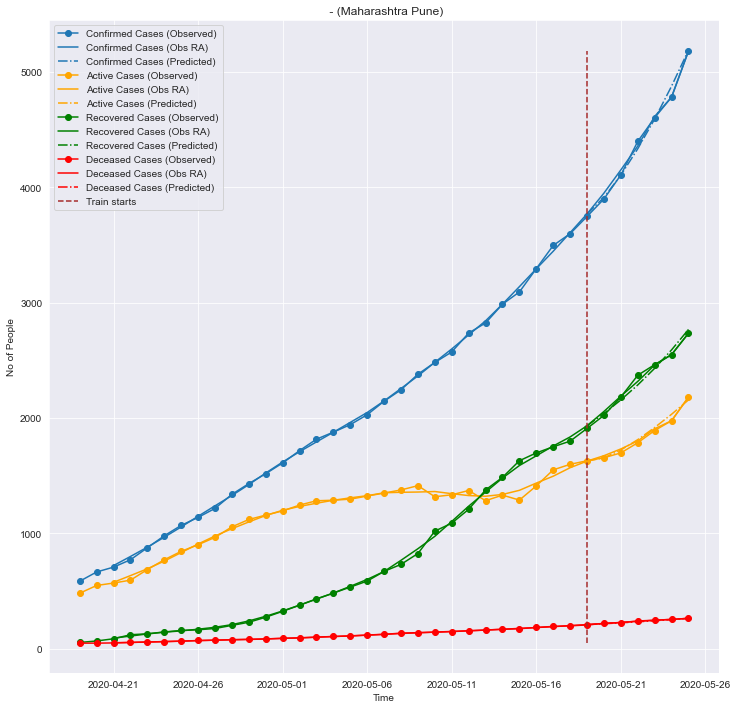

In [18]:
sns.set_style("dark")
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=False, 
                                                                     filename='../../data/data/official-pune-25-05-20.csv', 
                                                                     #filename='../../data/data/official-mumbai-27-05-20.csv', 
                                                                     initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, 
                                                                     val_period=0, 
                                                                     train_on_val=True, 
                                                                     data_from_tracker=False, 
                                                                     filename='../../data/data/official-pune-25-05-20.csv', 
                                                                     #filename='../../data/data/official-mumbai-27-05-20.csv', 
                                                                     initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

## Create Master Loss Dataframe

### M1 Loss

In [19]:
predictions_dict.keys()

dict_keys([('Maharashtra', 'Pune')])

In [60]:
predictions_dict[districts_to_show[0]]['m2']['df_district']

,date,state,district,total_infected,hospitalised,recovered,deceased
0,2020-04-19,Maharashtra,Pune,586,482,55,49
1,2020-04-20,Maharashtra,Pune,666,549,68,49
2,2020-04-21,Maharashtra,Pune,708,570,87,51
3,2020-04-22,Maharashtra,Pune,772,595,122,55
4,2020-04-23,Maharashtra,Pune,876,687,130,59
5,2020-04-24,Maharashtra,Pune,980,772,146,62
6,2020-04-25,Maharashtra,Pune,1070,845,159,66
7,2020-04-26,Maharashtra,Pune,1139,902,165,72
8,2020-04-27,Maharashtra,Pune,1217,966,176,75
9,2020-04-28,Maharashtra,Pune,1339,1057,203,79


In [59]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in districts_to_show:
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                            val  \
                 hospitalised total_infected deceased recovered hospitalised   
Maharashtra Pune         3.06           0.74     0.69      3.07          2.3   

                                                    
                 total_infected deceased recovered  
Maharashtra Pune           3.41     3.78      6.31

### M2 Loss

In [22]:
#predictions_dict[('Maharashtra','Pune')]['m2']
predictions_dict[districts_to_show[0]]['m2']

{'data_from_tracker': False,
 'best_params': {'E_hosp_ratio': 1.4801267761126702,
  'I_hosp_ratio': 0.4099956163606638,
  'P_fatal': 0.09385220091825557,
  'P_severe': 0.547359808002762,
  'T_inc': 4.601036980660309,
  'T_inf': 3.7052067662775685,
  'T_recov_severe': 13.454347984977218,
  'lockdown_R0': 1.4168998444054473},
 'default_params': {'N': 10000000.0,
  'lockdown_day': -55,
  'lockdown_removal_day': 12,
  'T_hosp': 0.001,
  'starting_date': Timestamp('2020-05-19 00:00:00'),
  'observed_values': date              2020-05-19 00:00:00
  state                     Maharashtra
  district                         Pune
  total_infected                 3769.4
  hospitalised                   1626.8
  recovered                      1933.2
  deceased                        209.6
  Name: 28, dtype: object},
 'variable_param_ranges': {'lockdown_R0': <hyperopt.pyll.base.Apply at 0x13a2a5a90>,
  'T_inc': <hyperopt.pyll.base.Apply at 0x13a2a5898>,
  'T_inf': <hyperopt.pyll.base.Apply at 0x13a2

In [23]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                 hospitalised total_infected deceased recovered
Maharashtra Pune         1.21           0.68     1.36      1.56

## Plot Forecasts

getting forecasts ..


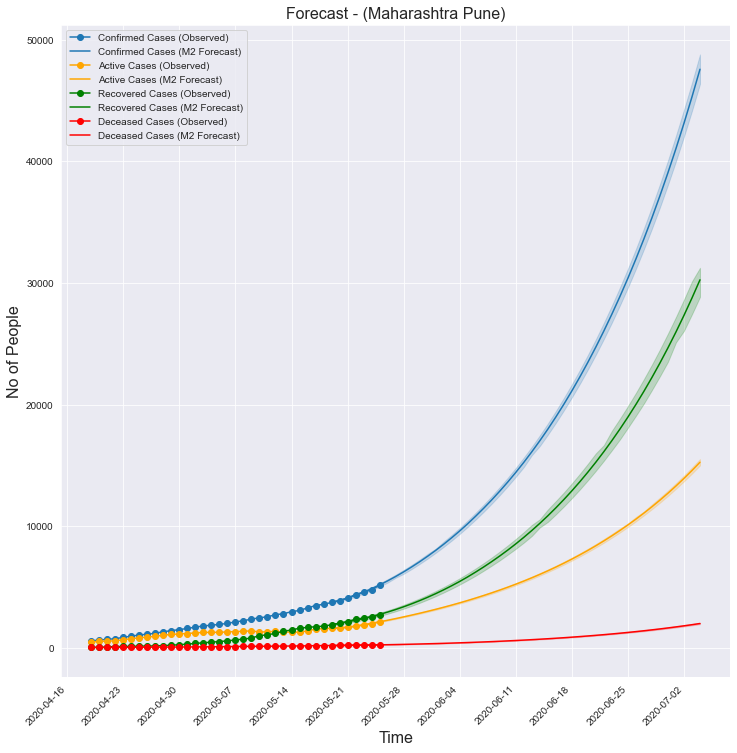

In [24]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=True)

## Create and Save Output CSV

In [25]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..


In [26]:
write_csv(df_output, '../../output-pune-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [27]:
losses_array = np.array([trial['result']['loss'] for trial in predictions_dict[(state, district)]['m2']['trials']])
least_losses_indices = np.argsort(losses_array)
np.sort(losses_array)

array([3.83666737e+00, 4.09231877e+00, 4.10038301e+00, ...,
       1.00000000e+10, 1.00000000e+10, 1.00000000e+10])

In [28]:
params_array = []
for trial in predictions_dict[(state, district)]['m2']['trials']:
    params_dict = copy.copy(trial['misc']['vals'])
    for key in params_dict.keys():
        params_dict[key] = params_dict[key][0]
    params_array.append(params_dict)

params_array = np.array(params_array)

In [29]:
least_losses_indices[:10]

array([1330,  805, 1309,  583, 1421, 1430, 1365, 1305, 1209,  720])

In [30]:
params_array[least_losses_indices[:10]]

array([{'E_hosp_ratio': 1.4801267761126702, 'I_hosp_ratio': 0.4099956163606638, 'P_fatal': 0.09385220091825557, 'P_severe': 0.547359808002762, 'T_inc': 4.601036980660309, 'T_inf': 3.7052067662775685, 'T_recov_severe': 13.454347984977218, 'lockdown_R0': 1.4168998444054473},
       {'E_hosp_ratio': 1.5196538233722439, 'I_hosp_ratio': 0.3822548428578137, 'P_fatal': 0.09410227778530689, 'P_severe': 0.5457571717112847, 'T_inc': 4.194807002250753, 'T_inf': 3.873406505890644, 'T_recov_severe': 13.870130929479828, 'lockdown_R0': 1.2548423444029275},
       {'E_hosp_ratio': 1.5452258773520013, 'I_hosp_ratio': 0.4259646544814809, 'P_fatal': 0.09146179473463384, 'P_severe': 0.5180246833667488, 'T_inc': 4.579099921729773, 'T_inf': 3.6721048186505847, 'T_recov_severe': 12.692029202779379, 'lockdown_R0': 1.3562344571060607},
       {'E_hosp_ratio': 1.4916562371774362, 'I_hosp_ratio': 0.5452483945133693, 'P_fatal': 0.07844674579430753, 'P_severe': 0.4451558921223972, 'T_inc': 4.347839643611083, 'T_in

In [31]:
np.sort(losses_array)[:10]

array([3.83666737, 4.09231877, 4.10038301, 4.18223023, 4.31149868,
       4.53844812, 4.54250138, 4.5517517 , 4.55220352, 4.57635042])

In [32]:
predictions_dict[('Maharashtra', 'Pune')]['m2']['best_params']

{'E_hosp_ratio': 1.4801267761126702,
 'I_hosp_ratio': 0.4099956163606638,
 'P_fatal': 0.09385220091825557,
 'P_severe': 0.547359808002762,
 'T_inc': 4.601036980660309,
 'T_inf': 3.7052067662775685,
 'T_recov_severe': 13.454347984977218,
 'lockdown_R0': 1.4168998444054473}

In [33]:
#predictions_array = [get_forecast(predictions_dict[('Maharashtra', 'Pune')],
#                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]
predictions_array = [get_forecast(predictions_dict[districts_to_show[0]],
                                  best_params=params_dict) for params_dict in params_array[least_losses_indices[:10]]]

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


In [34]:
params_dict['post_lockdown_R0']

KeyError: 'post_lockdown_R0'

In [35]:
#df_true = predictions_dict[('Maharashtra', 'Pune')]['m1']['df_district']
df_true = predictions_dict[districts_to_show[0]]['m2']['df_district']

sns.set_style("darkgrid")
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['total_infected'],
        '-o', color='C0', label='Confirmed Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    sns.lineplot(x="date", y="total_infected", data=df_prediction,
                 ls='-', label='Confirmed Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['total_infected'].iloc[-1],
             s= params_dict[i['lockdown_R0'])
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

SyntaxError: invalid syntax (<ipython-input-35-8fcd73aba94a>, line 14)

In [36]:
df_true

NameError: name 'df_true' is not defined

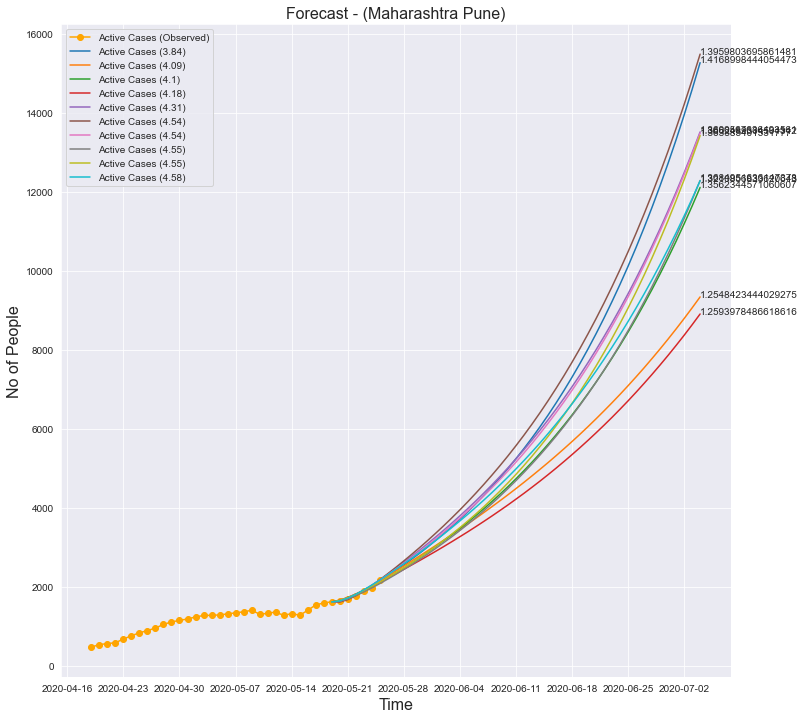

In [37]:
#df_true = predictions_dict[('Maharashtra', 'Pune')]['m1']['df_district']
df_true = predictions_dict[districts_to_show[0]]['m2']['df_district']
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
for i, df_prediction in enumerate(predictions_array):
    loss_value = np.around(np.sort(losses_array)[:10][i], 2)
    params_dict = params_array[least_losses_indices[:10]]
    true_r0 = params_dict[i]['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
    #if true_r0 > 1.7:
    #    continue
    #if true_r0 == 0.59 or true_r0 == 1.04:
    #    continue
    sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                 ls='-', label='Active Cases ({})'.format(loss_value))
    plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)
    
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
# plt.yscale('log')
plt.xlabel('Time', fontsize=16)
plt.legend()
plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
#plt.grid()
plt.show()     

## Check varying R0 values

In [57]:
def set_r0_multiplier(params_dict, mul):
    new_params = params_dict.copy()
    new_params['post_lockdown_R0']= params_dict['lockdown_R0']*mul
    return new_params

In [62]:
which_compartments

NameError: name 'which_compartments' is not defined

In [76]:
df_district = predictions_dict[districts_to_show[0]]['m2']['df_district']
df_train_nora, df_val_nora, df_true_fitting = train_val_split(
                df_district, train_rollingmean=False, val_rollingmean=False, val_size=0)

for key in params_to_plot:
    print("R0", params_to_plot[key]['lockdown_R0'])
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    df_predictions = get_forecast(predictions_dict[('Maharashtra', 'Pune')],
                                train_fit = "m2",
                                best_params = best_params_dict)
    df_loss = calculate_loss(df_train_nora, df_val_nora, df_predictions, train_period=7,
                             train_on_val = True, which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    print(df_loss.sum())

splitting data ..
R0 1.1900365275884162
getting forecasts ..
train    4.437962
dtype: float64
R0 1.243573241268517
getting forecasts ..
train    5.635409
dtype: float64
R0 1.3604168754599146
getting forecasts ..
train    5.560228
dtype: float64


In [54]:
params_array[least_losses_indices[:10]]

array([{'E_hosp_ratio': 1.4801267761126702, 'I_hosp_ratio': 0.4099956163606638, 'P_fatal': 0.09385220091825557, 'P_severe': 0.547359808002762, 'T_inc': 4.601036980660309, 'T_inf': 3.7052067662775685, 'T_recov_severe': 13.454347984977218, 'lockdown_R0': 1.4168998444054473},
       {'E_hosp_ratio': 1.5196538233722439, 'I_hosp_ratio': 0.3822548428578137, 'P_fatal': 0.09410227778530689, 'P_severe': 0.5457571717112847, 'T_inc': 4.194807002250753, 'T_inf': 3.873406505890644, 'T_recov_severe': 13.870130929479828, 'lockdown_R0': 1.2548423444029275},
       {'E_hosp_ratio': 1.5452258773520013, 'I_hosp_ratio': 0.4259646544814809, 'P_fatal': 0.09146179473463384, 'P_severe': 0.5180246833667488, 'T_inc': 4.579099921729773, 'T_inf': 3.6721048186505847, 'T_recov_severe': 12.692029202779379, 'lockdown_R0': 1.3562344571060607},
       {'E_hosp_ratio': 1.4916562371774362, 'I_hosp_ratio': 0.5452483945133693, 'P_fatal': 0.07844674579430753, 'P_severe': 0.4451558921223972, 'T_inc': 4.347839643611083, 'T_in

In [56]:
high_ind = 
losses_array[least_losses_indices[:10]]

array([3.83666737, 4.09231877, 4.10038301, 4.18223023, 4.31149868,
       4.53844812, 4.54250138, 4.5517517 , 4.55220352, 4.57635042])

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Pune-low-0.9.csv
Pune-low-1.csv
Pune-low-1.1.csv
Pune-low-1.25.csv


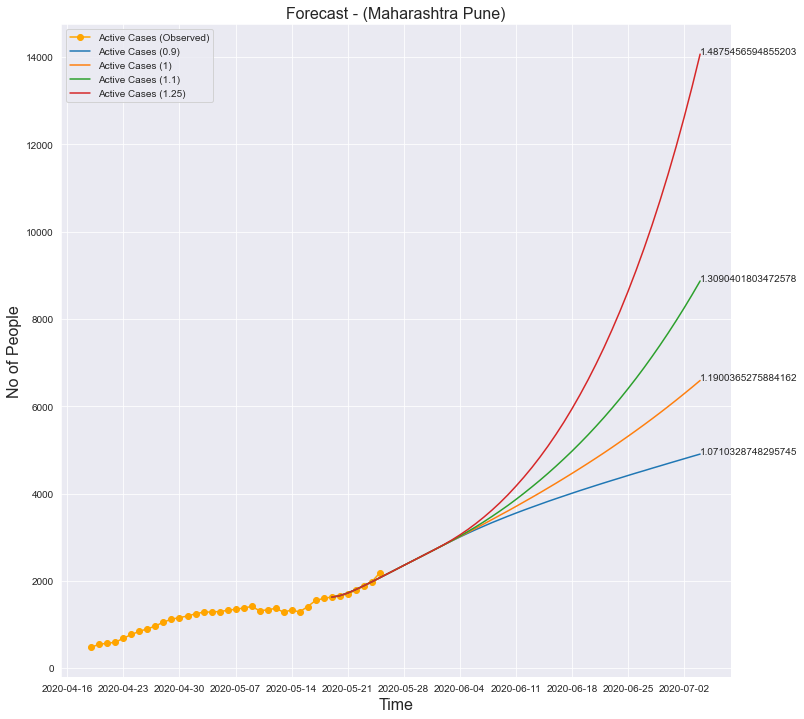

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Pune-medium-0.9.csv
Pune-medium-1.csv
Pune-medium-1.1.csv
Pune-medium-1.25.csv


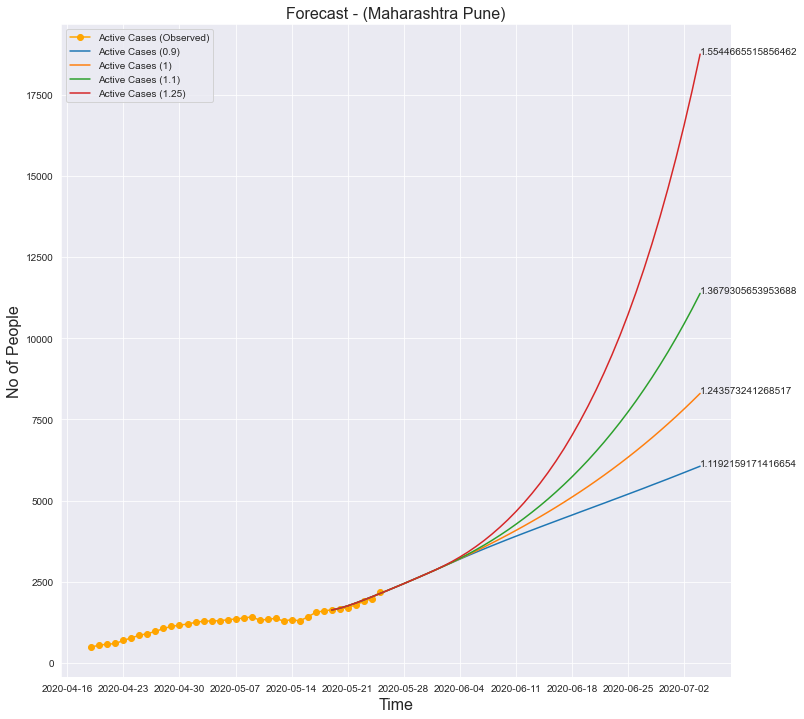

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
Pune-high-0.9.csv
Pune-high-1.csv
Pune-high-1.1.csv
Pune-high-1.25.csv


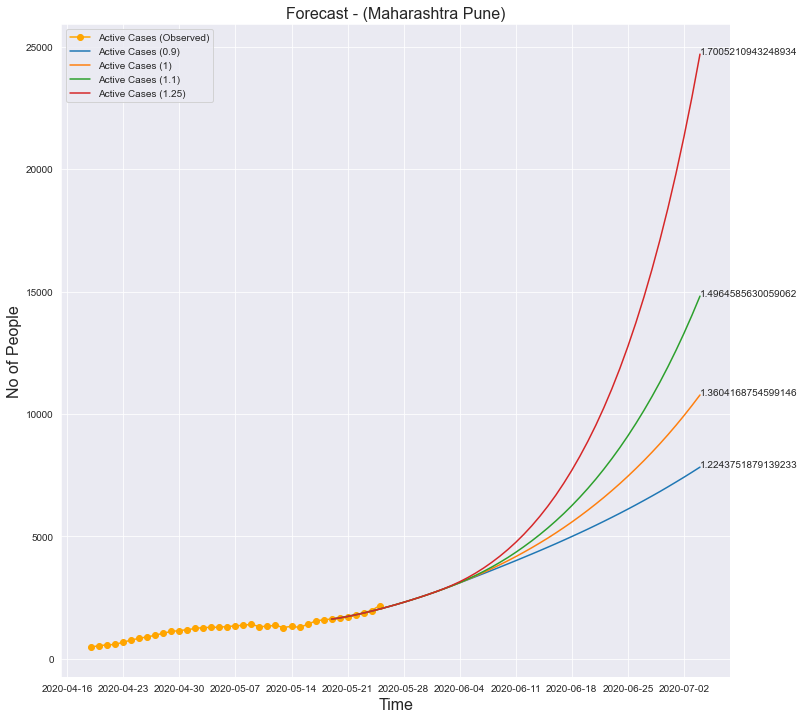

In [50]:
#df_true = predictions_dict[('Maharashtra', 'Pune')]['m1']['df_district']
df_true = predictions_dict[('Maharashtra', 'Pune')]['m2']['df_district']

for key in params_to_plot:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(df_true['date'], df_true['hospitalised'],
        '-o', color='orange', label='Active Cases (Observed)')
    best_params_dict = params_to_plot[key]#predictions_dict[districts_to_show[0]]['m2']['best_params']
    predictions_array_mul = [get_forecast(predictions_dict[('Maharashtra', 'Pune')],
                                train_fit = "m2",
                                best_params=set_r0_multiplier(best_params_dict, mul))
                                 for mul in multipliers]
    for i, df_prediction in enumerate(predictions_array_mul):
        filename = "Pune-" + key + "-" + str(multipliers[i]) + ".csv"
        print(filename)
        df_prediction[columns_for_csv].to_csv("../../outputs/pune-28-05-2020/"+filename)
        #loss_value = np.around(np.sort(losses_array)[:10][i], 2)
        label = multipliers[i]
        true_r0 = label*best_params_dict['lockdown_R0'] #np.around(params_dict[i]['lockdown_R0']*params_dict[i]['intervention_amount'], 2)
        #if true_r0 > 1.7:
        #    continue
        #if true_r0 == 0.59 or true_r0 == 1.04:
        #    continue
        sns.lineplot(x="date", y="hospitalised", data=df_prediction,
                     ls='-', label='Active Cases ({})'.format(label))
        plt.text(x=df_prediction['date'].iloc[-1], y=df_prediction['hospitalised'].iloc[-1], s=true_r0)

    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People', fontsize=16)
    # plt.yscale('log')
    plt.xlabel('Time', fontsize=16)
    plt.legend()
    plt.title('Forecast - ({} {})'.format(region[0], region[1]), fontsize=16)
    #plt.grid()
    plt.show()     

In [ ]:
columns = ['forecastRunDate', 'regionType', 'region', 'model_name', 'error_function', 'error_value', 'current_total', 'current_active', 'current_recovered',
           'current_deceased', 'current_hospitalized', 'current_icu', 'current_ventilator', 'predictionDate', 'active_mean', 'active_min',
           'active_max', 'hospitalized_mean', 'hospitalized_min', 'hospitalized_max', 'icu_mean', 'icu_min', 'icu_max', 'deceased_mean',
           'deceased_min', 'deceased_max', 'recovered_mean', 'recovered_min', 'recovered_max', 'total_mean', 'total_min', 'total_max']

region = districts_to_show[0]

df_final = pd.DataFrame(columns=columns)
for params_dict in params_array[least_losses_indices[:10]]:
    df_output = create_region_csv(predictions_dict[region], region=region[1], regionType='district', best_params=params_dict,
                                  initialisation='intermediate', train_period=7, icu_fraction=0.02)
    df_final = pd.concat([df_final, df_output], ignore_index=True)
    

In [ ]:
df_final.to_csv('../../outputs/pune-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [ ]:
df_final

In [ ]:
for index, params_dict in enumerate(params_array[least_losses_indices[:10]]):
    print('Loss - ', np.around(losses_array[least_losses_indices[:10][index]], 2))
    params_dict_temp = copy.copy(params_dict)
    params_dict_temp['true_R0'] = params_dict_temp['lockdown_R0']#*params_dict_temp['intervention_amount']
    #del params_dict_temp['intervention_amount']
    del params_dict_temp['lockdown_R0']
    for key in params_dict_temp.keys():
        params_dict_temp[key] = np.around(params_dict_temp[key], 2)
    print('Params - ', params_dict_temp)
    print('\n')